# Evaluate model on graph

This script takes a GNN model and evaluates a graph on it, saving real and predicted datasets as .pt

In [1]:
#Get the current working directory
import os
cwd = os.getcwd()
file_path = cwd + '/points_50.csv'
edge_path = cwd + '/grap_50.csv'
model_path = cwd + '/model_150_0.pth'

save_ref = 'ref_data_50.pt'
save_pred = 'pred_data_50.pt'

In [2]:
#Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import Tensor
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.3.1+cu121


In [3]:
df=pd.read_csv(file_path)

#Round the values of the dataset to 4 decimal places
df = df.round(4)

#Add a column to use as index from 0 to the length of the dataset
df['n_label'] = range(0, len(df))

#delete the column p_label
df = df.drop('p_label', axis=1)

df

,x,y,z,N_side,N_layer,t_label,phi,eta,q,pt,d0,z0,n_label
0,-0.1120,-9.9682,-6.3331,8,1,T0,-1.6049,-0.6008,-1,48.2712,0.2156,0.0220,0
1,-0.4144,-19.8918,-12.6639,8,2,T0,-1.6049,-0.6008,-1,48.2712,0.2156,0.0220,1
2,-0.6930,-29.8162,-18.9948,8,3,T0,-1.6049,-0.6008,-1,48.2712,0.2156,0.0220,2
3,-0.9483,-39.7538,-25.3337,8,4,T0,-1.6049,-0.6008,-1,48.2712,0.2156,0.0220,3
4,-1.1794,-49.6794,-31.6646,8,5,T0,-1.6049,-0.6008,-1,48.2712,0.2156,0.0220,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,55.6979,-16.0582,145.5239,11,6,T49,-0.2833,1.6506,-1,97.0001,-0.0522,0.0797,495
496,64.9905,-18.6876,169.7553,11,7,T49,-0.2833,1.6506,-1,97.0001,-0.0522,0.0797,496
497,74.2915,-21.3077,194.0006,11,8,T49,-0.2833,1.6506,-1,97.0001,-0.0522,0.0797,497
498,83.5955,-23.9170,218.2460,11,9,T49,-0.2833,1.6506,-1,97.0001,-0.0522,0.0797,498


In [4]:
import torch_geometric.transforms as T
from torch_geometric.data import HeteroData

In [5]:
#Empty hetero graph 
data=HeteroData()

#node names
nodes_s=df['n_label'].values
nodes_t=df['n_label'].values

#Add nodes to the graph
data['source'].node_id = torch.tensor(nodes_s, dtype=torch.long)
data['target'].node_id = torch.tensor(nodes_t, dtype=torch.long)

#Add node attributes, in this case the position of the points
data['source'].x = Tensor(df[['x', 'y', 'z']].values)
data['target'].x = Tensor(df[['x', 'y', 'z']].values)

In [6]:
# Importing the dataset
df_edge = pd.read_csv(edge_path)
df_edge = df_edge.replace({'weight':0.5}, 0.)

edge_index = torch.tensor([df_edge['Source'], df_edge['Target']], dtype=torch.long)
data['source', 'weight', 'target'].edge_index = edge_index

#edge attributes
weight_val = torch.from_numpy(df_edge['weight'].values).to(torch.float)
data['source', 'weight', 'target'].edge_label=weight_val

#check if the data is valid
data.validate(raise_on_error=True)

True

In [7]:
import torch_geometric.transforms as T
data = T.ToUndirected()(data)

del data['target', 'rev_weight', 'source'].edge_label
data.validate(raise_on_error=True)

True

In [8]:
torch.save(data,save_ref)
data

HeteroData(
  source={
    node_id=[500],
    x=[500, 3],
  },
  target={
    node_id=[500],
    x=[500, 3],
  },
  (source, weight, target)={
    edge_index=[2, 692],
    edge_label=[692],
  },
  (target, rev_weight, source)={ edge_index=[2, 692] }
)

## Load model

In [9]:
from torch_geometric.nn import SAGEConv, to_hetero

class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = torch.nn.Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['source'][row], z_dict['target'][col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Model(hidden_channels=32).to(device)

In [10]:
model.load_state_dict(torch.load(model_path))
model

Model(
  (encoder): GraphModule(
    (conv1): ModuleDict(
      (source__weight__target): SAGEConv((-1, -1), 32, aggr=mean)
      (target__rev_weight__source): SAGEConv((-1, -1), 32, aggr=mean)
    )
    (conv2): ModuleDict(
      (source__weight__target): SAGEConv((-1, -1), 32, aggr=mean)
      (target__rev_weight__source): SAGEConv((-1, -1), 32, aggr=mean)
    )
  )
  (decoder): EdgeDecoder(
    (lin1): Linear(in_features=64, out_features=32, bias=True)
    (lin2): Linear(in_features=32, out_features=1, bias=True)
  )
)

## Eval data

In [11]:
import torch.nn.functional as F
import math

with torch.no_grad():
    data = data.to(device)
    pred = model(data.x_dict, data.edge_index_dict,
                 data['source', 'target'].edge_index)
    pred = pred.clamp(min=0, max=1)
    target = data['source', 'target'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    print(f'Test RMSE: {rmse:.4f}')

sour = data['source', 'target'].edge_index[0].cpu().numpy()
tar = data['source', 'target'].edge_index[1].cpu().numpy()
pred = pred.cpu().numpy()
target = target.cpu().numpy()

pred_cleaned_0 = np.zeros(pred.size)
for id in range(sour.size):
    # First pass based on sources
    # get all possible edges with this source
    cands_sour = np.array(sour[sour==id])
    cands_pred = np.array(pred[sour==id])
    cands_ids = np.array(np.where(sour==id)[0])
    #print(cands_sour, cands_pred, cands_ids)
    max_score, max_id = -1.,-1
    # loop over cands to determine highest score
    for j in range(cands_sour.size):
        if cands_pred[j] > max(0.5,max_score):
            max_score = cands_pred[j]
            max_id = j
    # set to zero other preds
    if max_score > -1:
        for j in range(cands_sour.size):
            if j != max_id: pred_cleaned_0[cands_ids[j]] = 0.
            else: pred_cleaned_0[cands_ids[j]] = pred[cands_ids[j]]

pred_cleaned = np.zeros(pred.size)
for id in range(sour.size):
    # Second pass based on targets
    # get all possible edges with this target
    cands_t_tar = np.array(tar[tar==id])
    cands_t_pred = np.array(pred_cleaned_0[tar==id])
    cands_t_ids = np.array(np.where(tar==id)[0])
    max_score, max_id = -1.,-1
    # loop over cands to determine highest score
    for k in range(cands_t_tar.size):
        if cands_t_pred[k] > max(0.5,max_score):
            max_score = cands_t_pred[k]
            max_id = k
    # set to zero other preds
    if max_score > -1:
        for k in range(cands_t_tar.size):
            if k != max_id: pred_cleaned[cands_t_ids[k]] = 0.
            else: pred_cleaned[cands_t_ids[k]] = pred_cleaned_0[cands_t_ids[k]]
        

res=pd.DataFrame({'source': sour, 'target': tar, 'pred': pred, 'pred_cleaned': pred_cleaned, 'compare': target})
#Add a new column if pred is greater or equal than 0.5 then 1 else 0.5
res['weight'] = np.where(res['pred_cleaned']>=0.5, 1., 0.)
res

Test RMSE: 0.4848


,source,target,pred,pred_cleaned,compare,weight
0,0,1,0.809459,0.000000,1.0,0.0
1,0,321,0.840611,0.000000,1.0,0.0
2,0,441,0.892368,0.892368,1.0,1.0
3,10,11,0.706414,0.000000,1.0,0.0
4,10,451,0.689880,0.000000,1.0,0.0
...,...,...,...,...,...,...
687,468,469,1.000000,1.000000,1.0,1.0
688,478,189,1.000000,0.000000,0.0,0.0
689,478,479,1.000000,0.000000,1.0,0.0
690,488,489,1.000000,1.000000,1.0,1.0


In [12]:
res[res['source']==0]
res.size

4152

In [13]:
#compare column rating_1 with target and if they are equal add up
cont=0
for i in res.itertuples():
    if i.compare == i.weight:
        cont+=1

#Calculate the accuracy
accuracy = cont/len(res)
print('Accuracy:', accuracy)
print('Number of correct predictions:', cont)

connected_accuracy = 0.
nonconnected_accuracy = 0.

n1,n2=0,0
ncon,nncon=0,0
for i in res.itertuples():
    if i.compare == 0.:
        if i.compare == i.weight: n1+=1
        nncon+=1
    elif i.compare == 1.0:
        if i.compare == i.weight: n2+=1
        ncon+=1

connected_accuracy = n2/ncon
nonconnected_accuracy = n1/nncon

print(f'Accuracy in connected edges:     {n2}/{ncon} = {connected_accuracy}')
print(f'Accuracy in non connected edges: {n1}/{nncon} = {nonconnected_accuracy}')

Accuracy: 0.661849710982659
Number of correct predictions: 458
Accuracy in connected edges:     298/516 = 0.5775193798449613
Accuracy in non connected edges: 160/176 = 0.9090909090909091


In [14]:
pred_data = data

pred_data['source','weight','target']['edge_label'] = torch.tensor(res['weight'], dtype=torch.long)
print(pred_data['source','weight','target']['edge_label'])
torch.save(pred_data, save_pred)

tensor([0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
        1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
        0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,

In [15]:
def drawGraph(dataset, ax):

    x = dataset['source'].x
    ax.plot(x[:,0].numpy(), x[:,1].numpy(), 'g*')
    edge_index = dataset['source', 'weight', 'target'].edge_index
    edge_label = dataset['source', 'weight', 'target'].edge_label
    #edge_label_index = dataset['source', 'weight', 'target'].edge_label_index
    print(edge_index.shape)
    print(edge_label.shape)
    #print(edge_label_index.shape)

    for i, edge in enumerate(torch.t(edge_index)):
        edge1 = edge[0].numpy()
        edge2 = edge[1].numpy()
        if edge_label[i] > 0.75:
            x1, y1 = x[edge1,0], x[edge1,1]
            x2, y2 = x[edge2,0], x[edge2,1]
            xg = []
            xg.append(x1)
            xg.append(x2)
            yg = []
            yg.append(y1)
            yg.append(y2)
            ax.plot(xg, yg, 'r-')

torch.Size([2, 692])
torch.Size([692])
torch.Size([2, 692])
torch.Size([692])


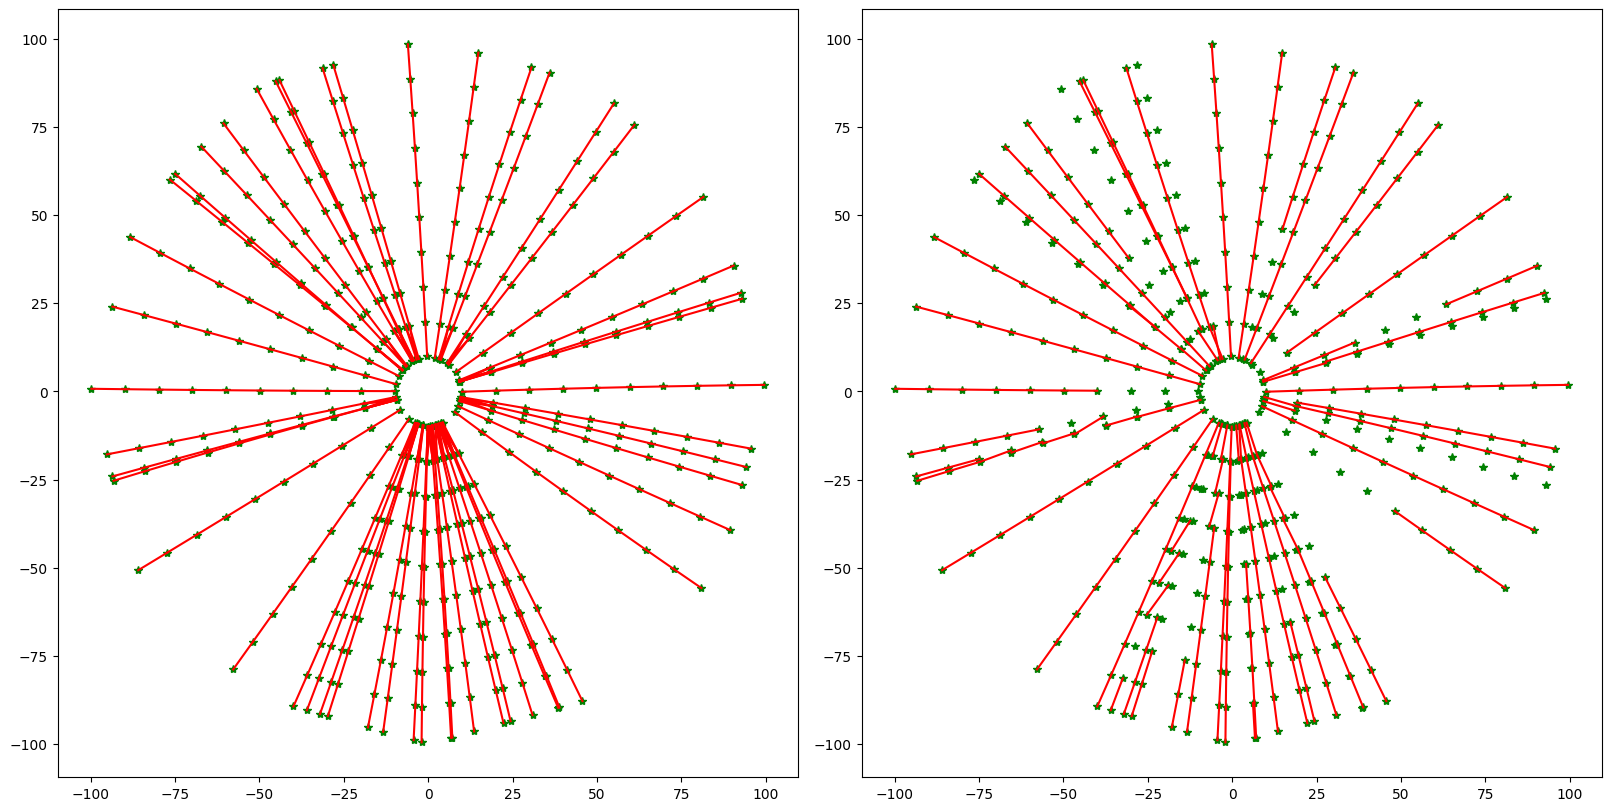

In [16]:
inputFile = 'ref_data_50.pt'
predFile = 'pred_data_50.pt'

dataset_real = torch.load(inputFile)
dataset_pred = torch.load(predFile)

fig = plt.figure(figsize = (16, 8), layout="constrained")
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
drawGraph(dataset_real, ax1)
drawGraph(dataset_pred, ax2)
plt.show()